In [117]:
#  _____  ___   ____  ______  __ __  ____     ___       _____   ___  _        ___    __ ______  ____  ___   ____  
# |     |/  _] /    ||      ||  |  ||    \   /  _]     / ___/  /  _]| |      /  _]  /  ]      ||    |/   \ |    \ 
# |   __/  [_ |  o  ||      ||  |  ||  D  ) /  [_     (   \_  /  [_ | |     /  [_  /  /|      | |  ||     ||  _  |
# |  |_|    _]|     ||_|  |_||  |  ||    / |    _]     \__  ||    _]| |___ |    _]/  / |_|  |_| |  ||  O  ||  |  |
# |   _]   [_ |  _  |  |  |  |  :  ||    \ |   [_      /  \ ||   [_ |     ||   [_/   \_  |  |   |  ||     ||  |  |
# |  | |     ||  |  |  |  |  |     ||  .  \|     |     \    ||     ||     ||     \     | |  |   |  ||     ||  |  |
# |__| |_____||__|__|  |__|   \__,_||__|\_||_____|      \___||_____||_____||_____|\____| |__|  |____|\___/ |__|__| 
# Lab II (Module II), Applied Machine Learning (DT4031)

# Please read lab instruction PDF and follow tasks in section "Lab Assignment"

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_regression
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import sys

plt.style.use('dark_background')

# k as in k for the k-NN model (number of neighbous)
k = 13
n_features = 100

In [119]:
X, y = make_regression(n_samples=1000, n_features=n_features, n_informative=10, n_targets=1, bias=2.0, effective_rank=10, tail_strength=0.9, noise=0.9, shuffle=True, coef=False, random_state=42)
X = stats.zscore(X)

In [120]:
# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [121]:
# Train both models using ALL 100 features
model_knn = KNeighborsRegressor(n_neighbors=k)
model_knn.fit(X_train, y_train)

model_lin_regr = LinearRegression()
model_lin_regr = model_lin_regr.fit(X_train, y_train)



In [122]:
# Predict the targets for the test set for the two learning algorithms
predictions_knn_test = model_knn.predict(X_test)
predictions_linreg_test = model_lin_regr.predict(X_test)

In [123]:
# Calculate the training set scores
R2_knn_train = model_knn.score(X_train, y_train)
R2_linreg_train= model_lin_regr.score(X_train, y_train)


# Calculate the test set scores
R2_knn_test = model_knn.score(X_test, y_test)
R2_linreg_test = model_lin_regr.score(X_test, y_test)


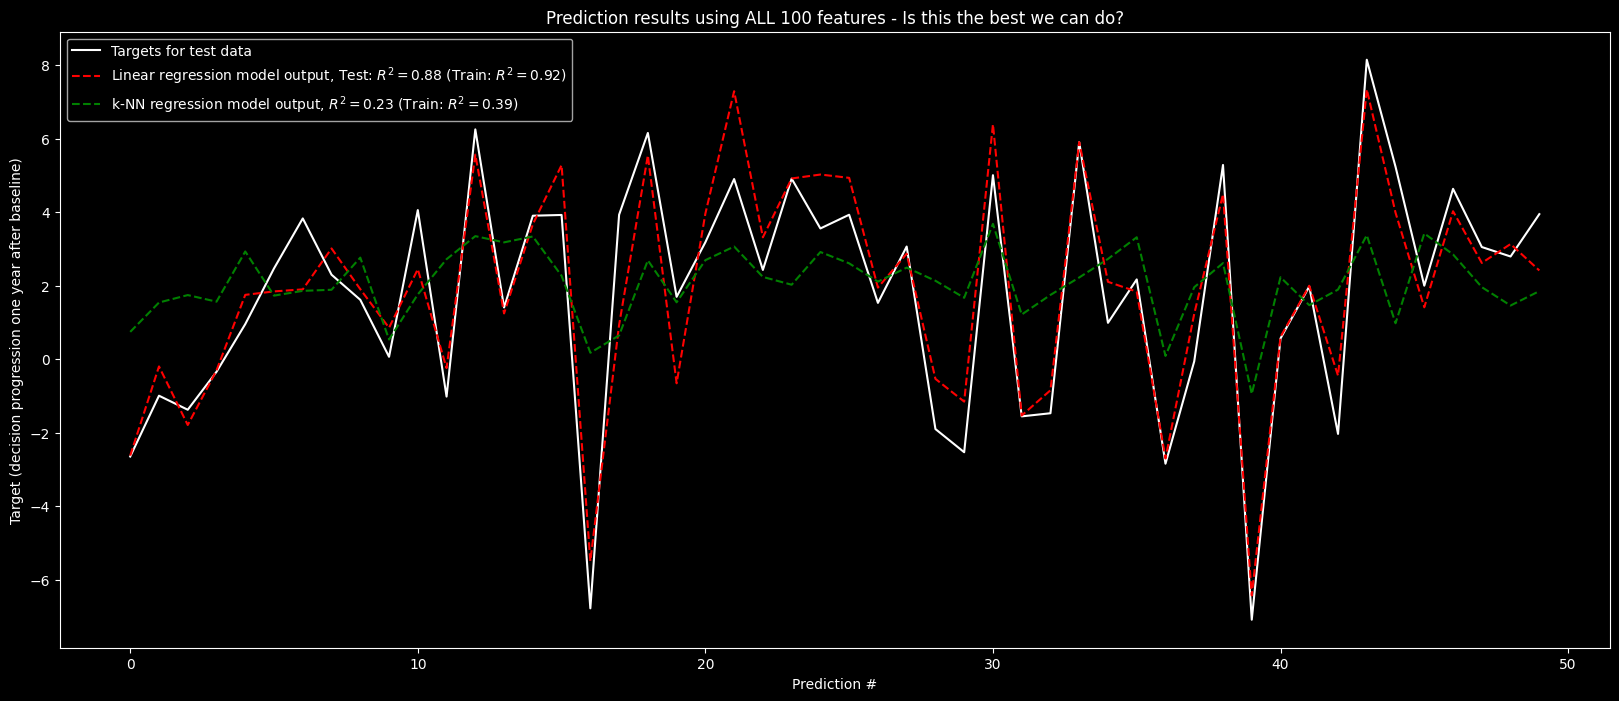

In [124]:
# Plot predictions for the models using ALL the features
plt.figure(figsize=(20,8))
plt.plot(y_test[0:50], 'w', label='Targets for test data')
plt.plot(predictions_linreg_test[0:50], 'r--', label='Linear regression model output, Test: $R^2=%2.2f$ (Train: $R^2=%2.2f$)' % (R2_linreg_test, R2_linreg_train))
plt.plot(predictions_knn_test[0:50], 'g--', label='k-NN regression model output, $R^2=%2.2f$ (Train: $R^2=%2.2f$)' % (R2_knn_test, R2_knn_train))
plt.legend()
plt.title("Prediction results using ALL 100 features - Is this the best we can do?")
plt.xlabel("Prediction #")
plt.ylabel("Target (decision progression one year after baseline)")

plt.show()

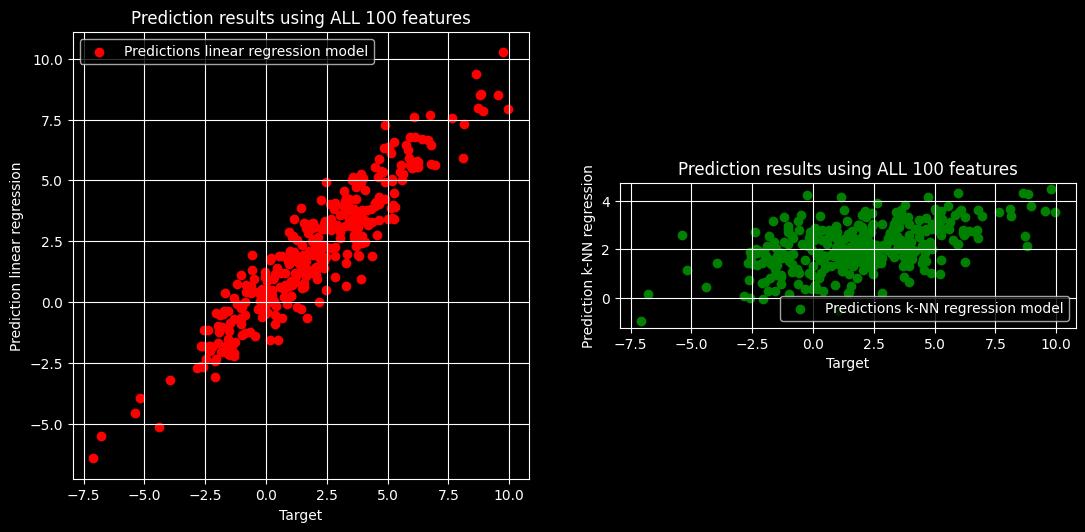

In [125]:
# Plot predictions and targets in a scatter plot
plt.figure(figsize=(20,10))

ax = plt.subplot(1,3,1)
ax.set_aspect('equal', adjustable='box')
plt.scatter(y_test, predictions_linreg_test, c='r', label="Predictions linear regression model")
plt.legend()
plt.title("Prediction results using ALL 100 features")
plt.xlabel("Target")
plt.ylabel("Prediction linear regression")
plt.grid()

ax = plt.subplot(1,3,2)
ax.set_aspect('equal', adjustable='box')
plt.scatter(y_test, predictions_knn_test, c='g', label="Predictions k-NN regression model")
plt.legend()
plt.title("Prediction results using ALL 100 features")
plt.xlabel("Target")
plt.ylabel("Prediction k-NN regression")
plt.grid()

In [126]:
def find_uninformative_feature_index(X_tr, y_tr, X_va, y_va, n_features, k_neighb=3, ml_algo_type='linear'):
    
    if ml_algo_type == 'linear':
        ml_regression_model = LinearRegression()
    elif ml_algo_type == 'knn':
        ml_regression_model = KNeighborsRegressor(n_neighbors=k_neighb)
    else:
        print("Invalid ML algorithm type (should be either linear or knn)")
        return -1, -1 

    feature_index_list = [i for i in range(n_features)]
    rsquareds = {}
    for feature_index in feature_index_list:
        feature_index_list_minus_feat_index = feature_index_list.copy()
        feature_index_list_minus_feat_index.remove(feature_index)
        rsquareds[feature_index] = ml_regression_model.fit(X_tr[:,feature_index_list_minus_feat_index], y_tr).score(X_va[:, feature_index_list_minus_feat_index], y_va)
        
    return max(rsquareds, key=rsquareds.get), rsquareds[max(rsquareds, key=rsquareds.get)]

In [127]:
feature_numb, r2 = find_uninformative_feature_index(X_train, y_train, X_test, y_test,  n_features, k_neighb=3, ml_algo_type='linear')

print(feature_numb, r2)

69 0.8776025924859711


In [128]:
def feature_removal( X_tr, y_tr, X_va, y_va, n_features=100, k_neighb=3, ml_algo_type='linear', stopping_condition = 10):

    if stopping_condition:

        tot_iter = n_features-stopping_condition
        all_r2s = []
        removed_features = []
  
        for i in range(tot_iter):
            
            feature_numb, r2 = find_uninformative_feature_index(X_tr, y_tr, X_va, y_va, n_features, k_neighb=3, ml_algo_type='linear')
            n_features -= 1

            X_tr, X_va = np.delete(X_tr, feature_numb, axis=1), np.delete(X_va, feature_numb, axis=1)

            all_r2s.append(r2)
            removed_features.append(feature_numb)
            
            progress = ((i+1) / tot_iter) * 100
            sys.stdout.write(f"\rRunning program iteration {i+1}/{tot_iter} [{progress:.2f}%]")  
            sys.stdout.flush()
        
        return X_tr, X_va, all_r2s, removed_features

    else:

        max_iters = 100
        all_r2s = []
        removed_features = []

  
        for i in range(max_iters):
            
            X_tr_prev, X_va_prev = X_tr.copy(), X_va.copy()

            feature_numb, r2 = find_uninformative_feature_index(X_tr, y_tr, X_va, y_va, n_features, k_neighb=3, ml_algo_type='linear')
            n_features -= 1

            X_tr, X_va = np.delete(X_tr, feature_numb, axis=1), np.delete(X_va, feature_numb, axis=1)

            all_r2s.append(r2)
            removed_features.append(feature_numb)

            
            progress = ((i+1) / max_iters) * 100
            sys.stdout.write(f"\rRunning program iteration {i+1}/{max_iters} (max iterations) [{progress:.2f}%] (of potential wait time)")  
            sys.stdout.flush()

            if len(all_r2s) >= 2 and all_r2s[-1] < all_r2s[-2]:

                all_r2s.pop()

                return X_tr_prev, X_va_prev, all_r2s, removed_features
            
    return X_tr, X_va, all_r2s, removed_features

In [129]:
# Run feature selction code using KNN
X_train_optimized, X_test_optimized, r2, removed_features_KNN = feature_removal(X_train, y_train, X_test, y_test, n_features=X_train.shape[1], k_neighb=3, ml_algo_type='knn', stopping_condition = None)

# Retrain the KNN model on the most informative features and print statistics
model = KNeighborsRegressor() 
knn_model_fit = model.fit(X_train_optimized, y_train)
predicted_KNN = knn_model_fit.predict(X_test_optimized)
predicted_train_KNN = knn_model_fit.predict(X_train_optimized)

mse_knn = np.mean((predicted_KNN-y_test)**2)
mae_knn = np.mean(abs(predicted_KNN-y_test))
test_r2_KNN = r2_score(y_test, predicted_KNN)
train_r2_KNN = r2_score(y_train, predicted_train_KNN)


print(f"\nNumber of features left after feature selection are [{X_train_optimized.shape[1]}] and the r2 for the final models fit is [{r2[-1]:.2f}].")
print(f"Final models performance increase/decrease after feature selection {r2[-1]-r2[0]:.2f}")
print(f"Mean Squared Error of the model is {mse_knn:.2f}")
print(f"Mean Absolute Error of the model is {mae_knn:.2f}")


Running program iteration 61/100 (max iterations) [61.00%] (of potential wait time)
Number of features left after feature selection are [40] and the r2 for the final models fit is [0.90].
Final models performance increase/decrease after feature selection 0.02
Mean Squared Error of the model is 4.78
Mean Absolute Error of the model is 1.74


In [130]:
# Run feature selection code using Linear Regression
X_train_optimized, X_test_optimized, r2, removed_features_LR = feature_removal(X_train, y_train, X_test, y_test, n_features=X_train.shape[1], k_neighb=3, ml_algo_type='linear', stopping_condition = None)

# Retrain the Linear Regression model on the most informative features and print statistics
model = LinearRegression() 
lr_model_fit = model.fit(X_train_optimized, y_train)
predicted_LR = lr_model_fit.predict(X_test_optimized)
predicted_train_LR = knn_model_fit.predict(X_train_optimized)


mse_lr = np.mean((predicted_LR-y_test)**2)
mae_lr = np.mean(abs(predicted_LR-y_test))
test_r2_LR = r2_score(y_test, predicted_LR)
train_r2_LR = r2_score(y_train, predicted_train_LR)

print(f"\nNumber of features left after feature selection are [{X_train_optimized.shape[1]}] and the r2 for the final models fit is [{r2[-1]:.2f}].")
print(f"Final models performance increase/decrease after feature selection {r2[-1]-r2[0]:.2f}")
print(f"Mean Squared Error of the model is {mse_lr:.2f}")
print(f"Mean Absolute Error of the model is {mae_lr:.2f}")

Running program iteration 61/100 (max iterations) [61.00%] (of potential wait time)
Number of features left after feature selection are [40] and the r2 for the final models fit is [0.90].
Final models performance increase/decrease after feature selection 0.02
Mean Squared Error of the model is 0.82
Mean Absolute Error of the model is 0.73


In [131]:
# KNN

print(f"training r2 of the model is: {train_r2_KNN}")
print(f"test r2 of the model is: {test_r2_KNN}")


training r2 of the model is: 0.5798854240367695
test r2 of the model is: 0.39732558813573415


In [132]:
# Linear regression

print(f"training r2 of the model is: {train_r2_LR}")
print(f"test r2 of the model is: {test_r2_LR}")


training r2 of the model is: 0.5798854240367695
test r2 of the model is: 0.896397708642844
